In [14]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 1

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')



last updated: 2016-09-19 

CPython 3.5.2
IPython 5.1.0


In [15]:
# imports 
import pandas as pd

# Need access to R
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import seaborn as sns
%matplotlib inline

In [30]:
%%cache -s clean_htseq_counts.pkl dfClean
# Import htseq read counts
df = pd.read_csv('../../data/zhenxia/htseq_merge_10755.txt', sep='\t', index_col=0)
df = df.T

# Drop ERCC and htseq summary rows
df = df.loc[~df.index.str.startswith('ERCC') & ~df.index.str.startswith('__')]

# Drop rows that are always zero
all_zero = (df == 0).all(axis=1)
dfClean = df[~all_zero]

# Drop columns that have less than 100,000 reads
dfClean = dfClean.loc[:, dfClean.sum() > 100000].copy()

# Fill missing values
dfClean.fillna(0)

print("There are {0} genes with no expression.".format(all_zero.sum()))

There are 483 genes with no expression.


In [32]:
%%cache -s edgeR_normalized_htseq_counts.pkl dfNorm
# Run edgeR in R and get normalized counts per million (CPM)
edgeR = importr('edgeR')
norm = edgeR.cpm(dfClean.iloc[:, :1000], log=True)

# Convert back to python dataframe
dfNorm = pandas2ri.ri2py_dataframe(norm)
dfNorm.columns = norm.colnames
dfNorm.index = norm.rownames

In [34]:
%%cache -s corr_edgeR_norm.pkl corr
# Calcculate pairwise correlation
corr = dfNorm.corr()

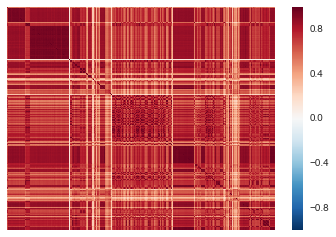

In [35]:
sns.heatmap(corr, yticklabels=False, xticklabels=False)

In [53]:
import numpy as np
from sklearn.cluster import k_means

In [50]:
kmeans = k_means(corr, n_clusters=12)

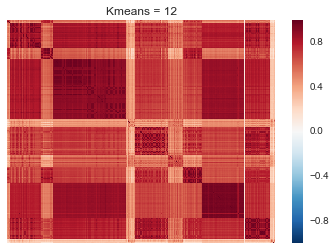

In [59]:
ax = sns.heatmap(corr.iloc[np.argsort(kmeans[1]), np.argsort(kmeans[1])], yticklabels=False, xticklabels=False)
ax.set_title('Kmeans = 12')

In [106]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage

In [110]:
lmap = linkage(pdist(corr), method='average')

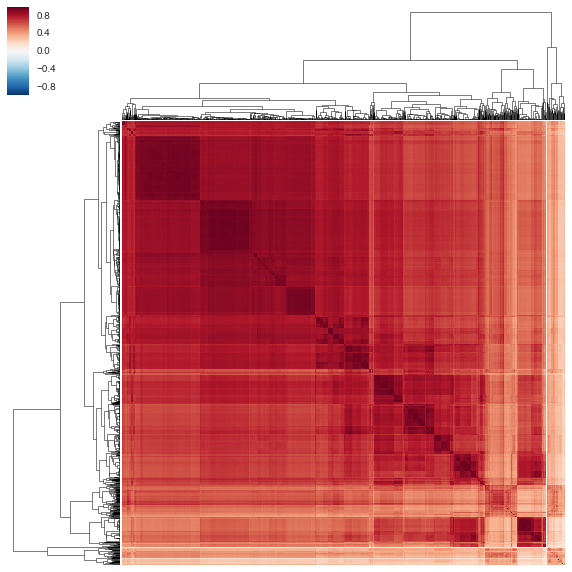

In [112]:
sns.clustermap(corr, row_linkage=lmap, col_linkage=lmap, xticklabels=False, yticklabels=False)

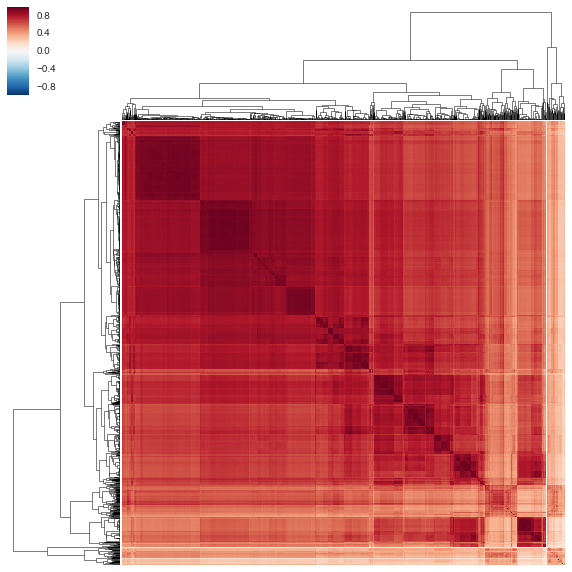

In [113]:
sns.clustermap(corr, row_cluster=True, col_cluster=True, xticklabels=False, yticklabels=False)